In [1]:
import numpy as np
import cv2
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Dropout, Flatten, Dense, MaxPool2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.optimizers import Adam, SGD
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.regularizers import l2
import tensorflow as tf
import pandas as pd

In [2]:
data_train = np.load('../input/Parkinson_disease_detection/Parkinson_disease_detection/train_set.npz', allow_pickle=True)
x_train = data_train['arr_0']
y_train = data_train['arr_1']

print(x_train.shape)
print(y_train.shape)

(72, 256, 256, 3)
(72,)


In [3]:
data_test = np.load('../input/Parkinson_disease_detection/Parkinson_disease_detection/test_set.npz', allow_pickle=True)
x_test = data_test['arr_0']
y_test = data_test['arr_1']

print(x_test.shape)
print(y_test.shape)

(30, 256, 256, 3)
(30,)


In [4]:
train_data_generator = ImageDataGenerator(rotation_range=360, 
                                    width_shift_range=0.0, 
                                    height_shift_range=0.0, 
                                  #  brightness_range=[0.5, 1.5],
                                    horizontal_flip=True, 
                                    vertical_flip=True)

x = list(x_train)
y = list(y_train)

x_aug_train = []
y_aug_train = []

for (i, v) in enumerate(y):
    x_img = x[i]
    x_img = np.array(x_img)
    x_img = np.expand_dims(x_img, axis=0)
    aug_iter = train_data_generator.flow(x_img, batch_size=1, shuffle=True)
    for j in range(70):
        aug_image = next(aug_iter)[0].astype('uint8')
        x_aug_train.append(aug_image)
        y_aug_train.append(v)
print(len(x_aug_train))
print(len(y_aug_train))

x_train = x + x_aug_train
y_train = y + y_aug_train
print(len(x_train))
print(len(y_train))

test_data_generator = ImageDataGenerator(rotation_range=360, 
                                    width_shift_range=0.0, 
                                    height_shift_range=0.0, 
                                   # brightness_range=[0.5, 1.5],
                                    horizontal_flip=True, 
                                    vertical_flip=True)

x = list(x_test)
y = list(y_test)

x_aug_test = []
y_aug_test = []

for (i, v) in enumerate(y):
    x_img = x[i]
    x_img = np.array(x_img)
    x_img = np.expand_dims(x_img, axis=0)
    aug_iter = test_data_generator.flow(x_img, batch_size=1, shuffle=True)
    for j in range(20):
        aug_image = next(aug_iter)[0].astype('uint8')
        x_aug_test.append(aug_image)
        y_aug_test.append(v)
print(len(x_aug_test))
print(len(y_aug_test))

x_test = x + x_aug_test
y_test = y + y_aug_test
print(len(x_test))
print(len(y_test))

5040
5040
5112
5112
600
600
630
630


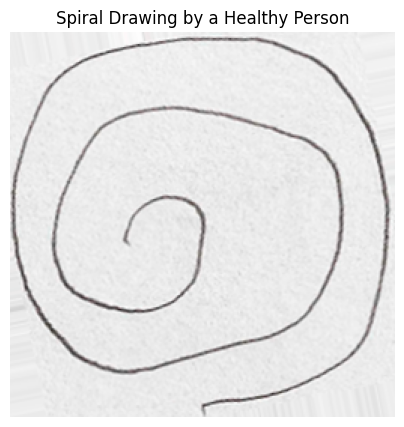

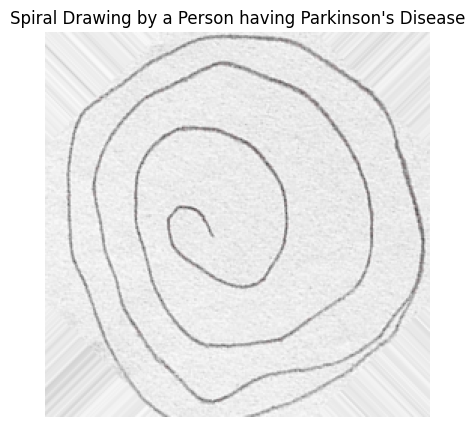

In [5]:
# print(y_test)
figure1 = plt.figure(figsize=(5, 5))
idx_healthy = [i for (i, v) in enumerate(y_train) if v=='healthy']
img_healthy = x_train[idx_healthy[-1]]
plt.imshow(img_healthy)
plt.title('Spiral Drawing by a Healthy Person')
plt.axis('off')
plt.show()

figure2 = plt.figure(figsize=(5, 5))
idx_parkinson = [i for (i, v) in enumerate(y_train) if v=='parkinson']
img_parkinson = x_train[idx_parkinson[-1]]
plt.imshow(img_parkinson)
plt.title("Spiral Drawing by a Person having Parkinson's Disease")
plt.axis('off')
plt.show()


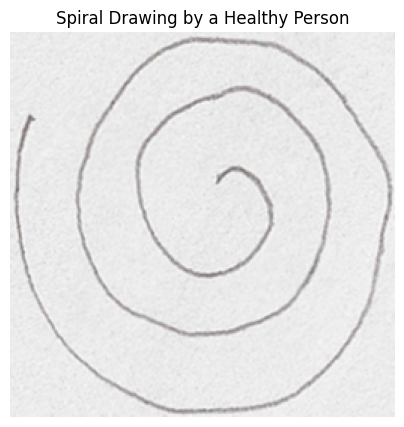

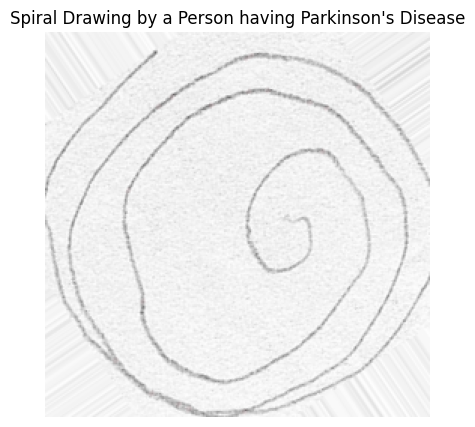

In [6]:
figure1 = plt.figure(figsize=(5, 5))
idx_healthy = [i for (i, v) in enumerate(y_test) if v=='healthy']
img_healthy = x_test[idx_healthy[-1]]
plt.imshow(img_healthy)
plt.title('Spiral Drawing by a Healthy Person')
plt.axis('off')
plt.show()

figure2 = plt.figure(figsize=(5, 5))
idx_parkinson = [i for (i, v) in enumerate(y_test) if v=='parkinson']
img_parkinson = x_test[idx_parkinson[-1]]
plt.imshow(img_parkinson)
plt.title("Spiral Drawing by a Person having Parkinson's Disease")
plt.axis('off')
plt.show()

In [7]:
for i in range(len(x_train)):
    img = x_train[i]
    img = cv2.resize(img, (128, 128))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    x_train[i] = img
    
for i in range(len(x_test)):
    img = x_test[i]
    img = cv2.resize(img, (128, 128))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    x_test[i] = img

x_train = np.array(x_train)
x_test = np.array(x_test)

x_train = x_train/255.0
x_test = x_test/255.0

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
print(y_train.shape)

label_encoder = LabelEncoder()
y_test = label_encoder.fit_transform(y_test)
print(y_test.shape)

(5112,)
(630,)


In [8]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(5112, 128, 128, 1)
(5112, 2)
(630, 128, 128, 1)
(630, 2)


In [9]:
def parkinson_disease_detection_model(input_shape=(128, 128, 1)):
    regularizer = tf.keras.regularizers.l2(0.001)
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Conv2D(128, (5, 5), padding='same', strides=(1, 1), name='conv1', activation='relu', 
                     kernel_initializer='glorot_uniform', kernel_regularizer=regularizer))
    model.add(MaxPool2D((9, 9), strides=(3, 3)))

    model.add(Conv2D(64, (5, 5), padding='same', strides=(1, 1), name='conv2', activation='relu', 
                     kernel_initializer='glorot_uniform', kernel_regularizer=regularizer))
    model.add(MaxPool2D((7, 7), strides=(3, 3)))
    
    model.add(Conv2D(32, (3, 3), padding='same', strides=(1, 1), name='conv3', activation='relu', 
                     kernel_initializer='glorot_uniform', kernel_regularizer=regularizer))
    model.add(MaxPool2D((5, 5), strides=(2, 2)))

    model.add(Conv2D(32, (3, 3), padding='same', strides=(1, 1), name='conv4', activation='relu', 
                     kernel_initializer='glorot_uniform', kernel_regularizer=regularizer))
    model.add(MaxPool2D((3, 3), strides=(2, 2)))    
    
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu', kernel_initializer='glorot_uniform', name='fc1'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax', kernel_initializer='glorot_uniform', name='fc3'))
    
    optimizer = Adam(3.15e-5)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [10]:
model= parkinson_disease_detection_model(input_shape=(128, 128, 1))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 128, 128, 128)     3328      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 40, 40, 128)      0         
 )                                                               
                                                                 
 conv2 (Conv2D)              (None, 40, 40, 64)        204864    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 64)       0         
 2D)                                                             
                                                                 
 conv3 (Conv2D)              (None, 12, 12, 32)        18464     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 32)         0

In [11]:
hist = model.fit(x_train, y_train, batch_size=128, epochs=100, validation_data=(x_test, y_test))

Epoch 1/100
40/40 [==============================] - 436s 10s/step - loss: 0.8527 - accuracy: 0.5029 - val_loss: 0.8484 - val_accuracy: 0.5000
Epoch 2/100
40/40 [==============================] - 498s 13s/step - loss: 0.8462 - accuracy: 0.4933 - val_loss: 0.8417 - val_accuracy: 0.5000
Epoch 3/100
40/40 [==============================] - 416s 10s/step - loss: 0.8391 - accuracy: 0.4939 - val_loss: 0.8349 - val_accuracy: 0.6698
Epoch 4/100
40/40 [==============================] - 397s 10s/step - loss: 0.8325 - accuracy: 0.5137 - val_loss: 0.8291 - val_accuracy: 0.5000
Epoch 5/100
40/40 [==============================] - 394s 10s/step - loss: 0.8262 - accuracy: 0.5201 - val_loss: 0.8233 - val_accuracy: 0.7190
Epoch 6/100
40/40 [==============================] - 536s 13s/step - loss: 0.8203 - accuracy: 0.5213 - val_loss: 0.8174 - val_accuracy: 0.7508
Epoch 7/100
40/40 [==============================] - 551s 14s/step - loss: 0.8154 - accuracy: 0.5323 - val_loss: 0.8123 - val_accuracy: 0.5016

Epoch 58/100
40/40 [==============================] - 532s 13s/step - loss: 0.4187 - accuracy: 0.8713 - val_loss: 0.4780 - val_accuracy: 0.8127
Epoch 59/100
40/40 [==============================] - 472s 12s/step - loss: 0.4184 - accuracy: 0.8672 - val_loss: 0.4553 - val_accuracy: 0.8286
Epoch 60/100
40/40 [==============================] - 413s 10s/step - loss: 0.4019 - accuracy: 0.8801 - val_loss: 0.4559 - val_accuracy: 0.8159
Epoch 61/100
40/40 [==============================] - 407s 10s/step - loss: 0.4037 - accuracy: 0.8768 - val_loss: 0.4869 - val_accuracy: 0.8143
Epoch 62/100
40/40 [==============================] - 409s 10s/step - loss: 0.3968 - accuracy: 0.8801 - val_loss: 0.4529 - val_accuracy: 0.8286
Epoch 63/100
40/40 [==============================] - 407s 10s/step - loss: 0.3916 - accuracy: 0.8822 - val_loss: 0.4441 - val_accuracy: 0.8238
Epoch 64/100
40/40 [==============================] - 407s 10s/step - loss: 0.3818 - accuracy: 0.8860 - val_loss: 0.4453 - val_accuracy:

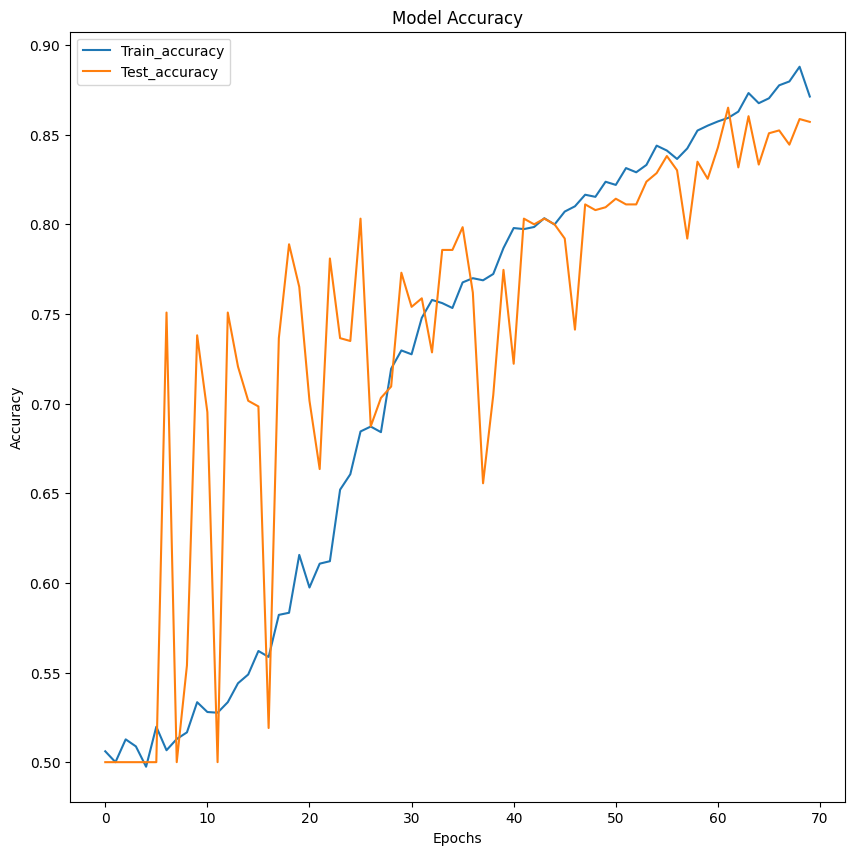

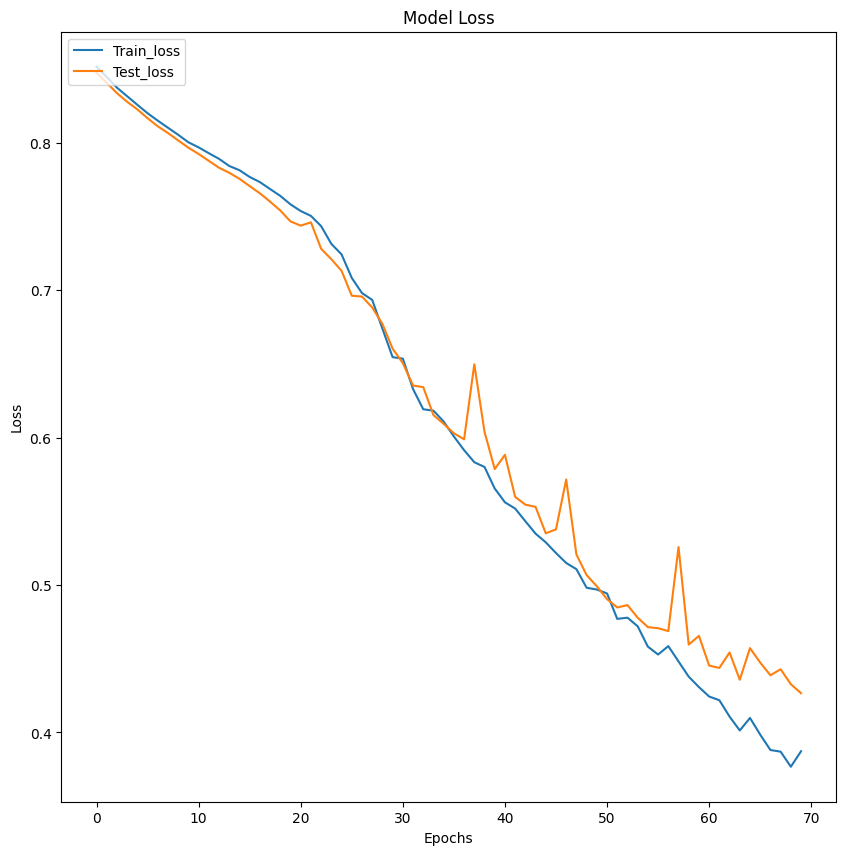

In [15]:
figure = plt.figure(figsize=(10, 10))
plt.plot(hist.history['accuracy'], label='Train_accuracy')
plt.plot(hist.history['val_accuracy'], label='Test_accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc="upper left")
plt.show()

figure2 = plt.figure(figsize=(10, 10))
plt.plot(hist.history['loss'], label='Train_loss')
plt.plot(hist.history['val_loss'], label='Test_loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="upper left")
plt.show()

In [16]:
ypred = model.predict(x_test)
ypred = np.argmax(ypred, axis=1)
y_test_pred = np.argmax(y_test, axis=1)
print(classification_report(y_test_pred, ypred))

20/20 [==============================] - 9s 423ms/step
              precision    recall  f1-score   support

           0       0.90      0.81      0.85       315
           1       0.82      0.91      0.86       315

    accuracy                           0.86       630
   macro avg       0.86      0.86      0.86       630
weighted avg       0.86      0.86      0.86       630



<AxesSubplot: >

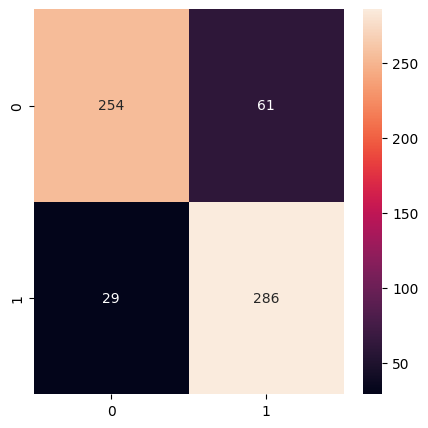

In [17]:
matrix = confusion_matrix(y_test_pred, ypred)
df_cm = pd.DataFrame(matrix, index=[0, 1], columns=[0, 1])
figure = plt.figure(figsize=(5, 5))
sns.heatmap(df_cm, annot=True, fmt='d')